<a href="https://colab.research.google.com/github/Anouar0000/Generation-of-bird-images-using-Gan/blob/main/BirdsStackGan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pickle
import random
import time

import PIL
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image
from keras import Input, Model
from keras import backend as K
from keras.callbacks import TensorBoard
from keras.layers import Dense, LeakyReLU, BatchNormalization, ReLU, Reshape, UpSampling2D, Conv2D, Activation, concatenate, Flatten, Lambda, Concatenate, Conv2DTranspose
from tensorflow.keras.optimizers import Adam
from matplotlib import pyplot as plt

In [ ]:
import pickle
from matplotlib import pyplot as plt
import cv2
import numpy as np
from keras.layers import Dense, LeakyReLU, BatchNormalization, ReLU, Reshape, UpSampling2D, Conv2D, Activation, concatenate, Flatten, Lambda, Concatenate, Conv2DTranspose

import tensorflow as tf
from tensorflow.keras.layers import (Dense, 
                                     BatchNormalization, 
                                     LeakyReLU, 
                                     Reshape, 
                                     Conv2DTranspose,
                                     Conv2D,
                                     Dropout,
                                     Flatten)
import matplotlib.pyplot as plt
import pickle
import cv2
import numpy as np
from tensorflow.keras import layers

In [ ]:
def loadData(path):
  with open(path, 'rb') as handle:
    return pickle.load(handle)

In [ ]:
# load the processed data
X_train = loadData('/content/drive/MyDrive/StackGanV1Project/training_testing/X_train.pickle')
embeddings_train = loadData('/content/drive/MyDrive/StackGanV1Project/training_testing/embeddings_train.pickle')

In [ ]:
# creating white and black images
BW_X_train = X_train # map( changeColor, X_train)
BW_X_train = list(BW_X_train)
BW_X_train = np.array(BW_X_train)
train_images = BW_X_train[:]
#############
train_images = np.array([cv2.resize(i, (28, 28), interpolation = cv2.INTER_AREA) for i in train_images])

In [ ]:
# train_images = train_images.reshape(train_images.shape[0], 64, 64, 1).astype('float32')
train_images_1 = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

BUFFER_SIZE = train_images_1.shape[0]
BATCH_SIZE = 256

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices((train_images_1, embeddings_train)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
train_dataset.element_spec

(TensorSpec(shape=(None, 28, 28, 3), dtype=tf.float64, name=None),
 TensorSpec(shape=(None, 1024), dtype=tf.float32, name=None))

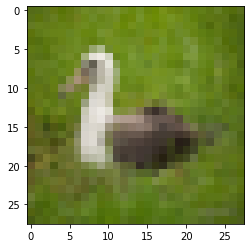

In [ ]:
plt.imshow((train_images_1[2]+1)/2)

# Creation de model Gan

1-generator

In [ ]:
def generate_c(x):
    mean = x[:, :128]
    log_sigma = x[:, 128:]
    stddev = K.exp(log_sigma)
    epsilon = K.random_normal(shape=K.constant((mean.shape[1],), dtype='int32'))
    c = stddev * epsilon + mean
    return c

In [ ]:
def build_ca_model():
    """
    Get conditioning augmentation model.
    Takes an embedding of shape (1024,) and returns a tensor of shape (256,)
    """
    input_layer = Input(shape=(1024,))
    x = Dense(256)(input_layer)
    x = LeakyReLU(alpha=0.2)(x)
    model = Model(inputs=[input_layer], outputs=[x])
    return model

In [ ]:
def build_embedding_compressor_model():
    """
    Build embedding compressor model
    """
    input_layer = Input(shape=(1024,))
    x = Dense(128)(input_layer)
    x = ReLU()(x)

    model = Model(inputs=[input_layer], outputs=[x])
    return model

In [ ]:
def make_generator_model():
    """
    Builds a generator model used in Stage-I
    """
    input_layer = Input(shape=(1024,))
    x = Dense(256)(input_layer)
    mean_logsigma = LeakyReLU(alpha=0.2)(x)

    c = Lambda(generate_c)(mean_logsigma)

    input_layer2 = Input(shape=(100,))

    x = Concatenate(axis=1)([c, input_layer2])

    x = layers.Dense(7*7*256, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Reshape((7, 7, 256))(x)

    x = layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)(x)
    
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
    
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')(x)
    

    model = Model(inputs=[input_layer, input_layer2], outputs= x)

    return model

In [ ]:
generator = make_generator_model()

In [ ]:
l = embeddings_train[0].reshape(1, embeddings_train.shape[1] )

In [ ]:
l.shape

(1, 1024)

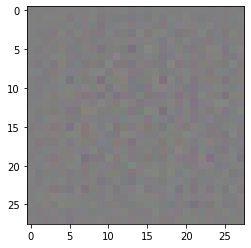

In [ ]:
# Create a random noise and generate a sample
noise = tf.random.normal([1, 100])
generated_image = generator([l, noise], training=False)
# Visualize the generated sample
plt.imshow((generated_image[0, :, :]+1)/2)

In [ ]:
generated_image.shape

TensorShape([1, 28, 28, 3])

In [ ]:
def make_discriminator_model():
    
    input_layer = Input(shape=(28, 28, 3))
    
    x = layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same')(input_layer)
    x = layers.LeakyReLU()(x)
    # x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU()(x)
    # x = layers.Dropout(0.3)(x)

    input_layer2 = Input(shape=(7, 7, 128))

    merged_input = concatenate([x, input_layer2])

    x2 = Conv2D(64 * 8, kernel_size=1,
                padding="same", strides=1)(merged_input)
    
    x2 = layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same')(x2)
    x2 = layers.LeakyReLU()(x2)
    x2 = layers.Dropout(0.3)(x2)

    x2 = layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')(x2)
    x2 = layers.LeakyReLU()(x2)
    x2 = layers.Dropout(0.3)(x2)

    x2 = Flatten()(x2)
    x2 = Dense(1)(x2)

    model = Model(inputs=[input_layer, input_layer2], outputs=[x2])

    return model

In [ ]:
discriminator = make_discriminator_model()
embedding_compressor_model = build_embedding_compressor_model()
embedding_compressor_model.compile(loss="binary_crossentropy", optimizer="adam")
compressed_embedding = embedding_compressor_model.predict_on_batch(l)
compressed_embedding = np.reshape(compressed_embedding, (-1, 1, 1, 128))
compressed_embedding = np.tile(compressed_embedding, (1, 7, 7, 1))

In [ ]:
compressed_embedding.shape

(1, 7, 7, 128)

In [ ]:
decision = discriminator([generated_image, compressed_embedding])
print(decision)

tf.Tensor([[-0.02811952]], shape=(1, 1), dtype=float32)


In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
import os

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)
checkpoint_dir_load = "/content/drive/MyDrive/testy" 

In [ ]:
EPOCHS = 1000
# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
num_examples_to_generate = 16
noise_dim = 100
seed = tf.random.normal([num_examples_to_generate, noise_dim])
emb = embeddings_train[:16]

In [ ]:
# tf.function annotation causes the function 
# to be "compiled" as part of the training
@tf.function
def train_step(images):
  
    # 1 - Create a random noise to feed it into the model
    # for the image generation
    noise = tf.random.normal([images[0].shape[0], noise_dim])
    
    # 2 - Generate images and calculate loss values
    # GradientTape method records operations for automatic differentiation.
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator([images[1], noise], training=True)
      
      compressed_embedding = embedding_compressor_model(images[1], training=False)
      compressed_embedding = tf.reshape(compressed_embedding, (-1, 1, 1, 128))
      compressed_embedding = tf.tile(compressed_embedding, (1, 7, 7, 1))

      real_output = discriminator([images[0], compressed_embedding], training=True)
      fake_output = discriminator([generated_images, compressed_embedding], training=True)


      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    # 3 - Calculate gradients using loss values and model variables
    # "gradient" method computes the gradient using 
    # operations recorded in context of this tape (gen_tape and disc_tape).
    
    # It accepts a target (e.g., gen_loss) variable and 
    # a source variable (e.g.,generator.trainable_variables)
    # target --> a list or nested structure of Tensors or Variables to be differentiated.
    # source --> a list or nested structure of Tensors or Variables.
    # target will be differentiated against elements in sources.

    # "gradient" method returns a list or nested structure of Tensors  
    # (or IndexedSlices, or None), one for each element in sources. 
    # Returned structure is the same as the structure of sources.
    gradients_of_generator = gen_tape.gradient(gen_loss, 
                                               generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, 
                                                discriminator.trainable_variables)


    # 4 - Process  Gradients and Run the Optimizer
    # "apply_gradients" method processes aggregated gradients. 
    # ex: optimizer.apply_gradients(zip(grads, vars))
    """
    Example use of apply_gradients:
    grads = tape.gradient(loss, vars)
    grads = tf.distribute.get_replica_context().all_reduce('sum', grads)
    # Processing aggregated gradients.
    optimizer.apply_gradients(zip(grads, vars), experimental_aggregate_gradients=False)
    """
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss


In [ ]:
import time
from IPython import display # A command shell for interactive computing in Python.

def train(dataset, epochs):
  # loss history 
  gen_hist = tf.TensorArray(tf.float32, size=0, dynamic_size=True)
  dis_hist = tf.TensorArray(tf.float32, size=0, dynamic_size=True)

  # A. For each epoch, do the following:
  for epoch in range(epochs):
    start = time.time()
    # 1 - For each batch of the epoch, 
    for image_batch in dataset:
      # 1.a - run the custom "train_step" function
      # we just declared above
      gen_loss, disc_loss = train_step(image_batch)

    # 2 - Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             [emb, seed])

    # 3 - Save the model every 5 epochs as 
    # a checkpoint, which we will use later
    if (epoch + 1) % 10 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    # 4 - Print out the completed epoch no. and the time spent
    print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    print("generator loss: ",gen_loss)
    print("dicriminator loss: ",disc_loss)
    gen_hist = gen_hist.write(epoch, gen_loss)
    dis_hist = dis_hist.write(epoch, disc_loss)

  # B. Generate a final image after the training is completed
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           [emb, seed])
  print("generator loss: ",gen_loss)
  print("dicriminator loss: ",disc_loss)


  return(gen_hist.stack(), dis_hist.stack())

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  # 1 - Generate images
  predictions = model(test_input, training=False)
  # 2 - Plot the generated images
  fig = plt.figure(figsize=(10,10))
  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow((predictions[i, :, :]+1)/2) #* 127.5 + 127.5  #, cmap='gray')
      plt.axis('off')
  # 3 - Save the generated images
  plt.savefig('/content/drive/MyDrive/StackGanV1Project/photo/image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir_load))

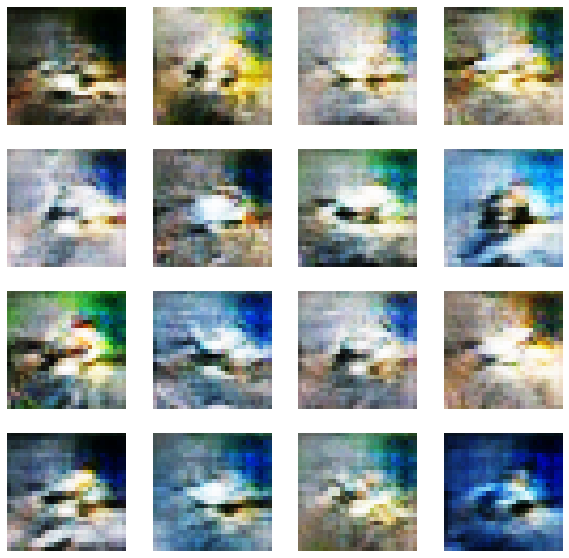

generator loss:  tf.Tensor(2.0755253, shape=(), dtype=float32)
dicriminator loss:  tf.Tensor(0.52236557, shape=(), dtype=float32)


In [ ]:
gen_loss, disc_loss = train(train_dataset, EPOCHS)

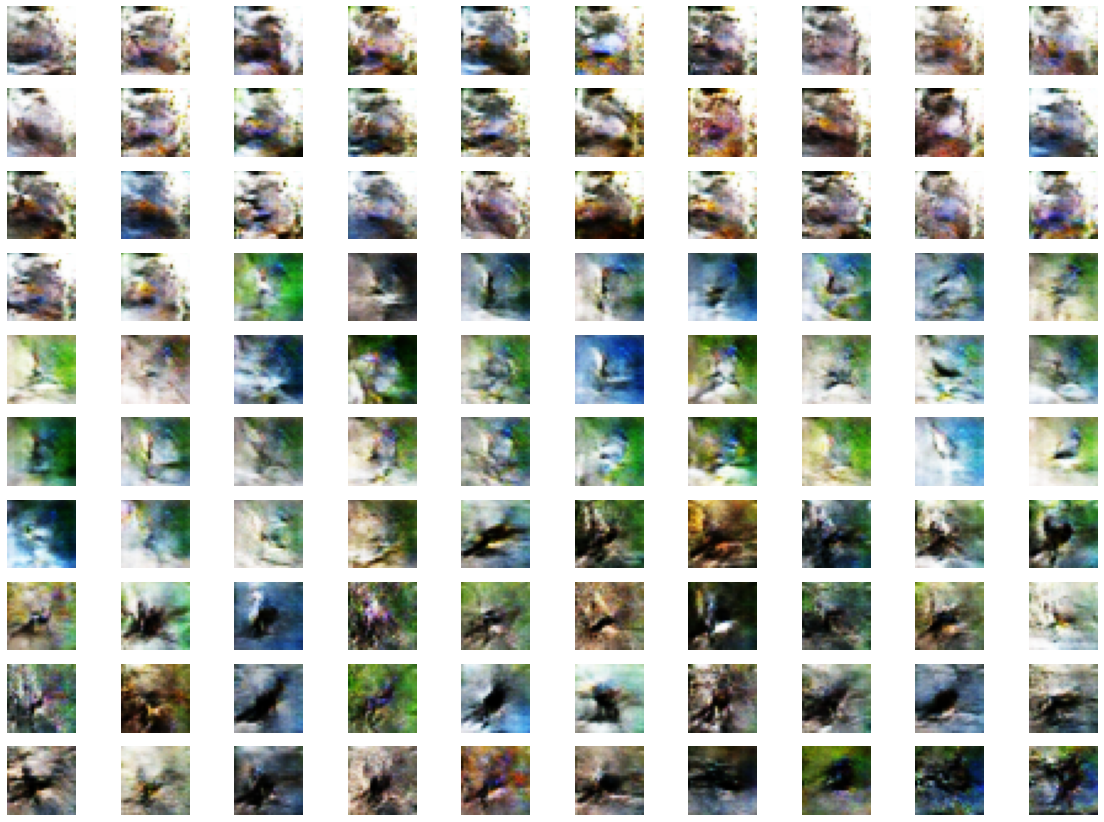

In [ ]:
seed2 = tf.random.normal([100, noise_dim])
oki = checkpoint.generator.predict([embeddings_train[:100], seed2])
# oki.shape
# plt.imshow(oki[4].reshape(64, 64), cmap='gray')

fig = plt.figure(figsize=(20,30))
for i in range(oki.shape[0]):
      plt.subplot(20, 10, i+1)
      plt.imshow((oki[i, :, :]+1)/2)
      plt.axis('off')